In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import unique
import scipy as sp
import seaborn as sns

In [16]:
# make categories for the features
ids = ['iid','pid']
facts = ['gender','age','race','samerace','age_o','race_o']
interests = ['sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
preferences = ['imprace','imprelig','date','go_out','exphappy']
desires = ['attr1_1','sinc1_1','intel1_1','fun1_1','shar1_1']
decisions = ['dec','dec_o','match']

orig_before = ids + facts + interests + preferences + desires
orig_after = decisions
orig = ids + facts + interests + preferences + desires + decisions

### Data Acquisition

In [17]:
#get data and check shape
sd = pd.read_csv('../Data/SpDat.csv')
sd= sd[orig]
sd.shape

(8378, 38)

### Data Cleaning: Removing Rows

In [18]:
#check for nulls
pd.DataFrame(sd.isnull().sum()).sort_values(0,ascending=False).head()

,0
shar1_1,121
age_o,104
exphappy,101
date,97
age,95


In [19]:
#drop nulls
sd= sd.dropna()
print(sd['match'].count())
print('lost rows=' + str(8378-sd['match'].count()))

8115
lost rows=263


In [20]:
#filter to ages 17-55 (only filters out one person aged 55)
sd.age.value_counts()
sd = sd[(sd['age'] < 50)]
print(sd['match'].count())
print('lost rows=' + str(8115-sd['match'].count()))

8109
lost rows=6


In [21]:
#find pid values that are not in iid
idx1 = pd.Index(sd['pid'])
idx2 = pd.Index(sd['iid'])
not_in_iid = idx1.difference(idx2).values
not_in_iid

array([  28.,  130.,  413.,  457.,  528.])

In [22]:
#remove the values not in iid
for n in not_in_iid:
    sd = sd[sd['pid']!=n]
print(sd['match'].count())
print('lost rows=' + str(8109-sd['match'].count()))

8038
lost rows=71


### Data Cleaning: Fixing Data Types

In [23]:
#change dtypes
to_int = ['age','age_o','race','race_o','iid','pid']
for a in to_int:
    sd[a] = sd[a].astype(int)

In [24]:
#fix date, go out, and race variables
sd['go_out'] = 8-sd['go_out']
sd['date'] = 8-sd['date']
sd.loc[sd['race']==6,'race']=5
sd.loc[sd['race_o']==6,'race']=5

In [25]:
#make a table of each individual person's averages
by_person1 = sd.pivot_table(index=sd['iid'])
by_person1= by_person1.reset_index()

#clean race data
#get race for each person
by_person1['race']= by_person1['race']//1
#replace race and race_o with the race that the person was most commonly listed as
for i in by_person1['iid']:
    sd.loc[sd['iid']==i,'race']= int(by_person1.loc[by_person1['iid']==i,'race'])
for i in by_person1['iid']:
    sd.loc[sd['pid']==i,'race_o']= int(by_person1.loc[by_person1['iid']==i,'race'])

#make fields for primary and partners average ratings from all partners
primary_averages = ['attr_o_avg','sinc_o_avg','intel_o_avg','fun_o_avg','dec_o_avg','dec_avg']
partner_averages = ['p_attr_o_avg','p_sinc_o_avg','p_intel_o_avg','p_fun_o_avg','p_dec_o_avg','p_dec_avg']
#make a table, rename columns, and merge onto sd
table_merger_iid = by_person1[['iid']+partner_on_primary+['dec_o','dec']]
table_merger_iid.columns= [['iid']+primary_averages]
sd2 = pd.merge(sd,table_merger_iid)
#rename columns and merge onto pid (this step also filters any pid persons who should be filtered out)
table_merger_iid.columns= [['pid']+partner_averages]
sd2 = pd.merge(sd2,table_merger_iid)

created_after = primary_averages + partner_averages

### Feature Engineering

In [26]:
#run this cell twice if there is error

#make new variables
sd2= sd
#make a field for combined interests, desires, and preferences
combined_interests = ['sports_com','tvsports_com','exercise_com','dining_com','museums_com','art_com','hiking_com','gaming_com','clubbing_com','reading_com','tv_com','theater_com','movies_com','concerts_com','music_com','shopping_com','yoga_com']
combined_desires = ['attr1_com','sinc1_com','intel1_com','fun1_com','shar1_com']
combined_preferences = ['imprace_com','imprelig_com','date_com','go_out_com','exphappy_com']
#start by making new columns that include the partners ratings
#make a table, rename columns, and merge onto pid (pid because these are partner's attributes)
table_merger_pid = by_person1[['iid'] + interests + desires + preferences]
table_merger_pid.columns= [['pid'] + combined_interests + combined_desires + combined_preferences]
sd2= pd.merge(sd2,table_merger_pid)
#actually combine interests
for col in combined_interests:
    num = combined_interests.index(col)
    col2 = interests[num]
    sd2[col]= sd2[col] * sd2[col2]
#actually combine desires
for col in combined_desires:
    num = combined_desires.index(col)
    col2 = desires[num]
    sd2[col]= sd2[col] * sd2[col2]
#actually combine preferences
for col in combined_preferences:
    num = combined_preferences.index(col)
    col2 = preferences[num]
    sd2[col]= sd2[col] * sd2[col2]

#add race dummies
race_df = pd.get_dummies(sd2['race'])
race_df.columns= ['black','white','hispanic','asian','other']
sd2= pd.concat([sd2,race_df],axis=1)

#combined race variable
#first number is male, second number is female.  based on the race key.
sd2['male_race']= 0
sd2['female_race']= 0
#males
sd2.loc[sd2['gender']==1,'male_race'] = sd2.loc[sd2['gender']==1,'race']
sd2.loc[sd2['gender']==0,'male_race'] = sd2.loc[sd2['gender']==0,'race_o']
#females
sd2.loc[sd2['gender']==0,'female_race'] = sd2.loc[sd2['gender']==0,'race']
sd2.loc[sd2['gender']==1,'female_race'] = sd2.loc[sd2['gender']==1,'race_o']
#interaction
sd2['comb_race']= sd2['male_race'].astype(str)+sd2['female_race'].astype(str)
#make a key
comb_race_key = pd.DataFrame(sd2['comb_race'].unique())
comb_race_key= comb_race_key.sort_values(0)
comb_race_key= comb_race_key.reset_index(drop=True)
#final variable
sd2['comb_race']=sd2['comb_race'].astype('category')
sd2['comb_race']= sd2['comb_race'].cat.codes

#make variables for female and male age
sd2['male_age']= 0
sd2['female_age']= 0
#males
sd2.loc[sd2['gender']==1,'male_age']=sd2.loc[sd2['gender']==1,'age']
sd2.loc[sd2['gender']==0,'male_age']=sd2.loc[sd2['gender']==0,'age_o']
#females
sd2.loc[sd2['gender']==0,'female_age']=sd2.loc[sd2['gender']==0,'age']
sd2.loc[sd2['gender']==1,'female_age']=sd2.loc[sd2['gender']==1,'age_o']

#age difference
sd2['age_diff']= sd2['male_age']-sd2['female_age']
age_diff_bins = [-20.1,-10.1,-5.1,-1.1,1,5,10,20]
sd2['age_difff'] = pd.cut(sd2['age_diff'], age_diff_bins)
sd2['age_difff'] = sd2['age_difff'].astype('category').cat.codes
sd2['comb_age']= sd2['age']+sd2['age_o']
#age group
age_bins = [17,24,30,42]
sd2['age_group'] = pd.cut(sd2['age'], age_bins)
sd2['age_group'] = sd2['age_group'].astype('category').cat.codes

#redo bypereson
by_person = sd2.pivot_table(index=sd2['iid'])
by_person.index=by_person.index.rename('goo')
by_person = by_person.reset_index()
by_person = by_person.rename(columns={'goo':'iid'})

#created variables groups
created = combined_interests + combined_desires + combined_preferences + ['age_diff','age_group','comb_race','comb_age']
age_gender = ['age_diff','comb_age','comb_race','male_race','female_race','male_age','female_age']
all_vars = orig + created

In [27]:
#combined iid dictionary
#first letter is male, second letter female
sd2['maleid']= 0
sd2['femaleid']= 0
#males
sd2.loc[sd2['gender']==1,'maleid'] = sd2.loc[sd2['gender']==1,'iid']
sd2.loc[sd2['gender']==0,'maleid'] = sd2.loc[sd2['gender']==0,'pid']
#females
sd2.loc[sd2['gender']==0,'femaleid'] = sd2.loc[sd2['gender']==0,'iid']
sd2.loc[sd2['gender']==1,'femaleid'] = sd2.loc[sd2['gender']==1,'pid']
#interaction
sd2['comb_id']= sd2['maleid'].astype(str) + sd2['femaleid'].astype(str)
#make a key
comb_id_key = pd.DataFrame(sd2['comb_id'].unique())
comb_id_key= comb_id_key.sort_values(0)
comb_id_key= comb_id_key.reset_index(drop=True)
#final variable
sd2['comb_id']=sd2['comb_id'].astype('category')
sd2['comb_id']= sd2['comb_id'].cat.codes


In [28]:
sd2['match'].count()

8038

## Data Exploration

In [29]:
#simple stats
by_person2 = sd.pivot_table(index=sd2['iid'])
print('Number of Dates: {}'.format(len(sd2['comb_id'].unique())))
print('Number of People: {}'.format(by_person2['iid'].count()))
match_rate = sd2['match'].mean()
print('Match Rate: {:.2%}'.format(match_rate))

Number of Dates: 4019
Number of People: 538
Match Rate: 16.62%


Females: 36.63%
Males: 47.87%


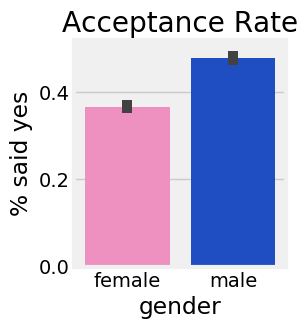

In [30]:
#examining gender
fig= plt.figure(figsize=(6,3),dpi=100)
plt.rcdefaults()
plt.style.use(style='fivethirtyeight')

#dec by gender
ax2= plt.subplot(122)
sns.barplot(x="gender", y="dec", data=sd2,palette=['xkcd:pink','xkcd:blue'])
ax2.set_ylabel('% said yes')
ax2.set_xticklabels(['female','male'])
plt.title('Acceptance Rate')


fema = sd2['dec'][sd2['gender']==0].sum()/sd2['dec'][sd2['gender']==0].count()
mal = sd2['dec'][sd2['gender']==1].sum()/sd2['dec'][sd2['gender']==1].count()
print('Females: {:.2%}\nMales: {:.2%}'.format(fema,mal))

Average Age
Females: 26.01
Males: 26.61


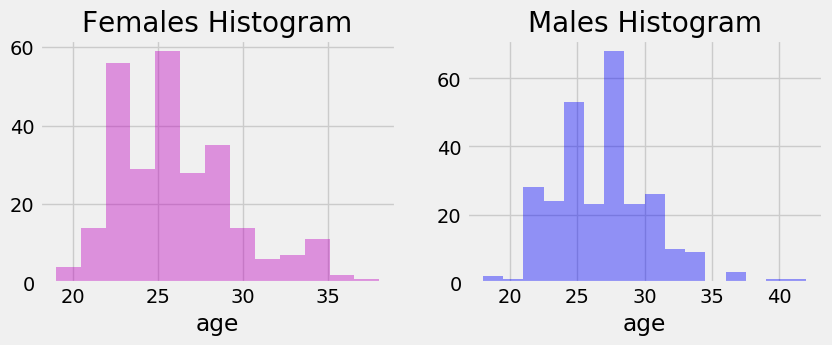

In [31]:
## examining age
fig= plt.figure(figsize=(9,3))
#males and females
female_ages = by_person['age'][by_person['gender']==0]
male_ages = by_person['age'][by_person['gender']==1]
#female age hist
ax1 = plt.subplot(121)
sns.distplot(female_ages,kde=False, color="m")
plt.title('Females Histogram')
#male age hist
plt.subplot(122)
sns.distplot(male_ages,kde=False, color="b")
plt.title('Males Histogram')
print('Average Age\nFemales: {:.2f}\nMales: {:.2f}'.format(female_ages.mean(),male_ages.mean()))

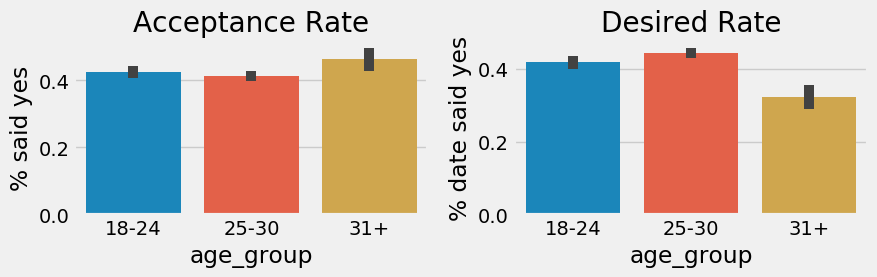

In [32]:
#examining age
fig= plt.figure(figsize=(9,3),dpi=100)
#dec by race
ax1= plt.subplot(121)


sns.barplot(x="age_group", y=sd2["dec"], data=sd2)
plt.title('Acceptance Rate')
ax1.set_xticklabels(('18-24','25-30','31+'))
ax1.set_ylabel('% said yes')



#dec_o by race
ax2= plt.subplot(122)
sns.barplot(x="age_group", y="dec_o", data=sd2)
plt.title('Desired Rate')
ax2.set_xticklabels(('18-24','25-30','31+'))
ax2.set_ylabel('% date said yes')


plt.tight_layout()


18-24: 16.11%
25-30: 17.67%
31+: 12.41%


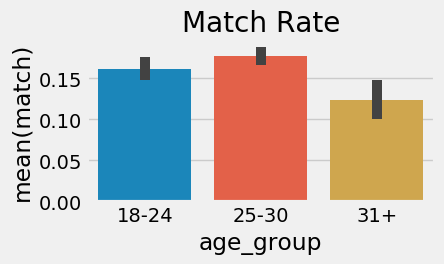

In [33]:
fig= plt.figure(figsize=(4,2))
age_bins = [17,24,30,42]
ax1 = plt.subplot(111)
sns.barplot(x="age_group", y="match",data=sd2)
plt.title('Match Rate')
ax1.set_xticklabels(('18-24','25-30','31+'))

ymean = omean = sd2['match'][sd2['age_group']==0].mean()
mmean = sd2['match'][sd2['age_group']==1].mean()
omean = sd2['match'][sd2['age_group']==2].mean()
print('18-24: {:.2%}\n25-30: {:.2%}\n31+: {:.2%}'.format(ymean,mmean,omean))


/Users/apple/anaconda3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


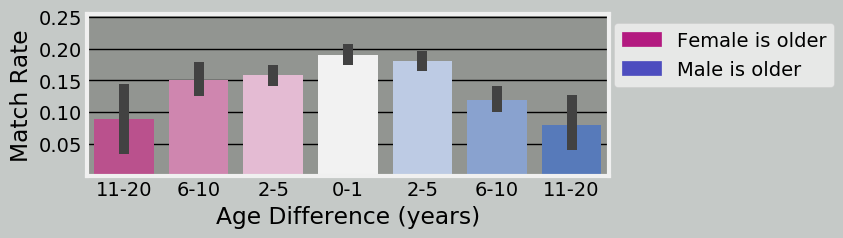

In [34]:
import matplotlib.patches as mpatches
#style
plt.rcdefaults()
plt.style.use(style='fivethirtyeight')
fig= plt.figure(figsize=(6,2),dpi=100)
fig.patch.set_facecolor('xkcd:silver')
pal = sns.diverging_palette(340, 255, sep=4,n=7)
ax1 = plt.subplot(111,axisbg= 'xkcd:gray')
ax1.grid(color='black')

#plot
sns.barplot(x=(sd2['age_difff']),y=sd2['match'],data=sd2,palette=pal)

#x-axis

ax1.set_xticklabels(('11-20','6-10','2-5','0-1','2-5','6-10','11-20'))

#y-axis
plt.ylim(0,.255)
ax1.set_yticks([.05,.1,.15,.2,.25])

#more style
pink_patch = mpatches.Patch(color=(.7,.1,.5), label='Female is older')
blue_patch = mpatches.Patch(color=(.3,.3,.75), label='Male is older')
plt.legend(handles=[pink_patch,blue_patch],loc=1,bbox_to_anchor=(1.45,1))
plt.ylabel('Match Rate')
plt.xlabel('Age Difference (years)')


1- African American
2- Caucasian/European
3- Latino/Hispanic 
4- Asian/Pacific Islander/Asian-American 
5- Other


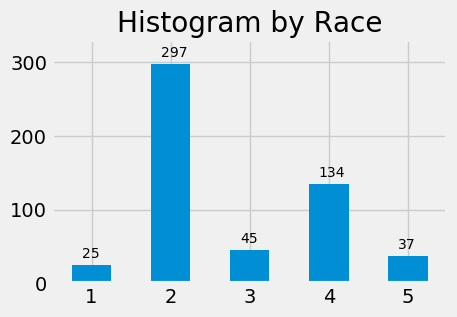

In [35]:
#examining race
plt.rcdefaults()
plt.style.use(style='fivethirtyeight')
fig= plt.figure(figsize=(10,3),dpi=100)

#race histogram
ax1= plt.subplot(121)
plt.hist(by_person['race'],bins=np.arange(1,7)-.25,width=.5)
plt.ylim(0,330)
plt.xlim(.5,5.5)
plt.title('Histogram by Race')
print('1- African American\n2- Caucasian/European\n3- Latino/Hispanic \n4- Asian/Pacific Islander/Asian-American \n5- Other')
for a in np.arange(0,5):
    height = int(ax1.patches[a].get_height())
    ax1.annotate(height, xy=(1, 1), xytext=(a+.875, height+10),size=10)

1- African American
2- Caucasian/European
3- Latino/Hispanic 
4- Asian/Pacific Islander/Asian-American 
6- Other


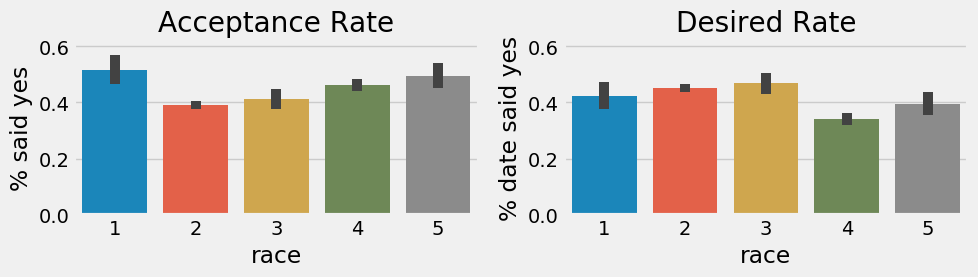

In [36]:
#examining race
fig= plt.figure(figsize=(10,3),dpi=100)
#dec by race
ax1= plt.subplot(121)
sns.barplot(x="race", y="dec", data=sd2)
plt.title('Acceptance Rate')
ax1.set_ylabel('% said yes')
plt.ylim(0,.625)
#dec_o by race
ax2=plt.subplot(122)
sns.barplot(x="race", y="dec_o", data=sd2)
plt.title('Desired Rate')
ax2.set_ylabel('% date said yes')
plt.ylim(0,.625)

plt.tight_layout()
#key
print('1- African American\n2- Caucasian/European\n3- Latino/Hispanic \n4- Asian/Pacific Islander/Asian-American \n6- Other')

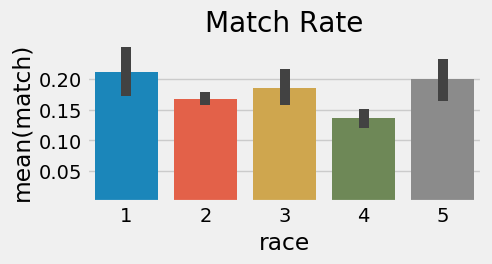

In [37]:
#gender and race
fig= plt.figure(figsize=(10,2),dpi=100)
ax1= plt.subplot(121)
sns.barplot(x="race", y=sd2["match"],data=sd2)
ax1.set_yticks([.05,.1,.15,.2])
plt.title('Match Rate')

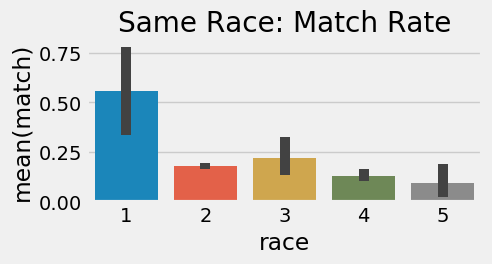

In [38]:
#gender and race
fig= plt.figure(figsize=(10,2),dpi=100)
ax1= plt.subplot(121)
sns.barplot(x="race", y=sd2["match"][sd2['samerace']==1],data=sd2)
plt.title('Same Race: Match Rate')

In [39]:
#interests correlation: top and bottom 5
jerry = pd.DataFrame(sd2[interests + ['match']].corr().loc[:,'match'].round(3)).sort_values('match',ascending=False)
top5 = jerry[1:6]
bot5 = jerry[-5:]
bot5 = bot5.sort_values('match')

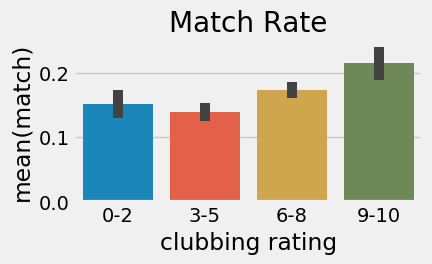

In [40]:
#examining match rate and clubbing
plt.rcdefaults()
plt.style.use(style='fivethirtyeight')
fig= plt.figure(figsize=(4,2),dpi=100)
ax1 = plt.subplot(111)
sns.barplot(x=(sd2["clubbing"]//3*3).astype(int), y="match", data=sd2)
plt.title('Match Rate')
ax1.set_xticklabels(['0-2','3-5','6-8','9-10'])
ax1.set_xlabel('clubbing rating')


In [41]:
over89 = sd2.loc[0:1]
over89 = over89.drop([0,1])
for i in combined_interests:
    over89= over89.append(sd2[sd2[i]>89])
newww = 5
over89 = over89.drop_duplicates()
len(over89)/2

1682.0

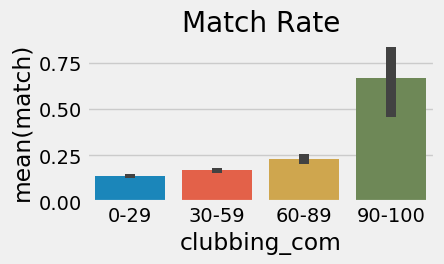

In [42]:
plt.rcdefaults()
plt.style.use(style='fivethirtyeight')
fig= plt.figure(figsize=(4,2),dpi=100)
ax1 = plt.subplot(111)
sns.barplot(x=(sd2["clubbing_com"]//30*30).astype(int), y="match", data=sd2)
plt.title('Match Rate')
ax1.set_xticklabels(['0-29','30-59','60-89','90-100'])

In [59]:
sd2.corr().sort_values('match',ascending=False)['match']

match           1.000000
dec             0.521999
dec_o           0.521999
go_out_com      0.088699
date_com        0.083853
clubbing_com    0.082651
fun1_com        0.067143
go_out          0.060432
date            0.059840
yoga_com        0.059193
clubbing        0.053570
fun1_1          0.044570
dining_com      0.043678
concerts_com    0.039205
exphappy_com    0.037202
art_com         0.035796
hiking_com      0.035157
yoga            0.031874
dining          0.030433
music_com       0.029211
art             0.028529
black           0.028167
exphappy        0.026771
concerts        0.025232
sports_com      0.024916
hiking          0.023484
other           0.023376
intel1_com      0.023207
reading_com     0.019617
intel1_1        0.018844
                  ...   
age_diff       -0.006951
age_difff      -0.007646
age_group      -0.010691
femaleid       -0.011264
pid            -0.011532
iid            -0.011532
maleid         -0.011832
tv             -0.014411
tv_com         -0.014628


## Modeling

In [43]:
from sklearn.model_selection import train_test_split
#split data into X and y 
X= sd2[combined_interests]
y= sd2['match']
#split data into train and test.
X_train, X_test, y_train, y_test = train_test_split(X,y)
X_test.shape

(2010, 17)

/Users/apple/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Train Accuracy,Test Accuracy,Precision,Recall,ROC AUC,PR AUC
Model,,,,,,
Random Forest,100.00%,95.72%,100.00%,75.71%,95.62%,90.83%
Logistic Regression,83.71%,82.39%,0.00%,0.00%,57.38%,22.83%
SVC,100.00%,95.72%,100.00%,75.71%,96.68%,93.08%
Gradient Boosting,85.85%,83.33%,73.17%,8.47%,72.39%,40.88%


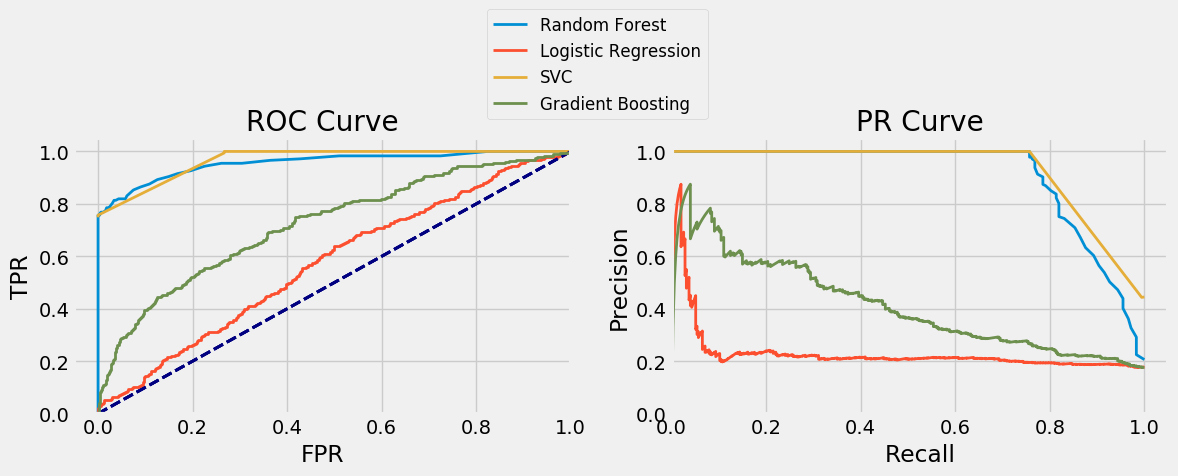

In [44]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc

classifiers = [RandomForestClassifier(max_features= 0.1, n_estimators=100,class_weight={0:.001,1:99.999}),LogisticRegression(),SVC(), GradientBoostingClassifier()]
class_text = ['Random Forest','Logistic Regression','SVC','Gradient Boosting']
columns = ['Model','Train Accuracy','Test Accuracy','Precision','Recall','ROC AUC','PR AUC']
the_df = pd.DataFrame(index=[0],columns=columns)
fig = plt.figure(figsize=(12,4),dpi=100)

for c in classifiers:
    
    #Fit Random Forest
    clf = c
    clf.fit(X_train,y_train)
    # test on the training and test set
    training = clf.score(X_train,y_train)
    test = clf.score(X_test,y_test)
    
    #probabilities
    if clf==classifiers[2]:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:,1]
    
    #ROC Numbers
    fpr, tpr, _ = roc_curve(y_test,y_score)
    roc_auc = roc_auc_score(y_test,y_score)
    
    #ROC Curve
    ax1= plt.subplot(121)
    lw = 2
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr, tpr,lw=lw, label= class_text[classifiers.index(c)])
    plt.xlim([-.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')

    #PR Numbers
    prec, recall, _ = precision_recall_curve(y_test,y_score)
    pr_auc = auc(recall,prec)
    prscore= precision_score(y_test,clf.predict(X_test))
    recscore= recall_score(y_test,clf.predict(X_test))
    
    #PR Curve
    ax2= plt.subplot(122)
    plt.plot(recall, prec, lw=lw, label= class_text[classifiers.index(c)])
    plt.xlim([0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    plt.legend(loc='upper center',bbox_to_anchor=(-.15,1.5,0,0),fontsize=12)
    
    #add to df
    the_df.loc[classifiers.index(c)] = [class_text[classifiers.index(c)],'{:.2%}'.format(training),
    '{:.2%}'.format(test),'{:.2%}'.format(prscore),'{:.2%}'.format(recscore),'{:.2%}'.format(roc_auc),'{:.2%}'.format(pr_auc)]

plt.tight_layout()
the_df = the_df.set_index('Model')
the_df

In [45]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
features = pd.DataFrame({'Features': X.columns,
             'Importance': clf.feature_importances_})
features.sort_values('Importance',ascending=False)

,Features,Importance
16,yoga_com,0.068260
8,clubbing_com,0.067720
6,hiking_com,0.067343
10,tv_com,0.062095
15,shopping_com,0.061490
1,tvsports_com,0.061351
13,concerts_com,0.060234
0,sports_com,0.059511
2,exercise_com,0.059313
4,museums_com,0.057755


    ax1= plt.subplot(d[c])
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
    plt.fill(fpr,tpr,facecolor='none',hatch='----',edgecolor='orange')
    plt.xlim([-.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR',size=13)
    plt.ylabel('TPR',size=13)
    plt.title('ROC: '+str(class_text[classifiers.index(c)]))
    plt.legend(loc="lower right",bbox_to_anchor=(1,0),fontsize=12)

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix
cm= pd.DataFrame(cm(y_test,clf.predict(X_test)).T)
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm

True,0,1
Predicted,,
0,1640,130
1,16,224


In [47]:
pd.DataFrame()

""


### Parameter Tuning

In [48]:
from sklearn.model_selection import GridSearchCV as gs

#### Random Forest

In [49]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
n_est = [10,25,50,100]
min_sampleaf = [1, 25, 50, 75, 100]
max_feat = [.1, .25, .5, .75]

grid = gs(estimator=RandomForestClassifier(),param_grid=dict(max_features=max_feat,n_estimators=n_est,min_samples_leaf=min_sampleaf))
grid.fit(X_test,y_test)
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score',ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,param_min_samples_leaf,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.074801,0.006280,0.852239,0.999502,0.1,1,50,"{'min_samples_leaf': 1, 'max_features': 0.1, '...",1,0.846269,1.000000,0.855224,0.998507,0.855224,1.000000,0.003343,0.000212,0.004222,0.000704
63,0.506197,0.012181,0.851741,1.000000,0.75,1,100,"{'min_samples_leaf': 1, 'max_features': 0.75, ...",2,0.841791,1.000000,0.856716,1.000000,0.856716,1.000000,0.022329,0.000623,0.007036,0.000000
3,0.147334,0.011736,0.851244,1.000000,0.1,1,100,"{'min_samples_leaf': 1, 'max_features': 0.1, '...",3,0.844776,1.000000,0.855224,1.000000,0.853731,1.000000,0.002630,0.000168,0.004614,0.000000
42,0.193352,0.005935,0.851244,0.999254,0.5,1,50,"{'min_samples_leaf': 1, 'max_features': 0.5, '...",3,0.840299,0.998507,0.852239,1.000000,0.861194,0.999254,0.005439,0.000104,0.008560,0.000609
23,0.249921,0.012969,0.850746,1.000000,0.25,1,100,"{'min_samples_leaf': 1, 'max_features': 0.25, ...",5,0.843284,1.000000,0.853731,1.000000,0.855224,1.000000,0.008977,0.001313,0.005312,0.000000
43,0.368234,0.010908,0.850249,1.000000,0.5,1,100,"{'min_samples_leaf': 1, 'max_features': 0.5, '...",6,0.843284,1.000000,0.850746,1.000000,0.856716,1.000000,0.011119,0.000125,0.005495,0.000000
1,0.041563,0.003487,0.850249,0.996766,0.1,1,25,"{'min_samples_leaf': 1, 'max_features': 0.1, '...",6,0.843284,0.999254,0.855224,0.997015,0.852239,0.994030,0.003881,0.000144,0.005074,0.002140
62,0.252554,0.006203,0.848756,0.999751,0.75,1,50,"{'min_samples_leaf': 1, 'max_features': 0.75, ...",8,0.843284,0.999254,0.852239,1.000000,0.850746,1.000000,0.008512,0.000484,0.003917,0.000352
22,0.127339,0.006461,0.848756,0.999751,0.25,1,50,"{'min_samples_leaf': 1, 'max_features': 0.25, ...",8,0.841791,1.000000,0.853731,0.999254,0.850746,1.000000,0.002707,0.000485,0.005074,0.000352
0,0.017788,0.001899,0.845274,0.978358,0.1,1,10,"{'min_samples_leaf': 1, 'max_features': 0.1, '...",10,0.841791,0.979104,0.847761,0.979104,0.846269,0.976866,0.001841,0.000176,0.002537,0.001055


#### SVC

In [51]:
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# this was the original run, however gamma proved to be useless and drastically increases cpu time
## the following kernel shows a faster grid search

gammas = [0.01,0.02,0.03,0.04,0.05,0.10,0.2,0.3,0.4,0.5]
Cs = np.array([.0001,.001,.01,.1,1])
kernels = ['linear','rbf','sigmoid','poly']

grid = gs(estimator=SVC(),param_grid=dict(C=Cs,kernel=kernels,gamma=gammas))
grid.fit(X_test,y_test)
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score',ascending=False)

In [ ]:
Cs = np.array([.0001,.001,.01,.1,1])
kernels = ['linear','rbf','sigmoid','poly']

grid = gs(estimator=SVC(),param_grid=dict(C=Cs,kernel=kernels))
grid.fit(X_test,y_test)
pd.DataFrame(grid.cv_results_).sort_values('mean_test_score',ascending=False)